In [2]:
import logging
import os
import pathlib
import time

import hydra
from omegaconf import DictConfig
from collections.abc import MutableMapping
import wandb

import scanpy as sc
import pandas as pd

from trainer import train_model
from evaluator import evaluate_model
from data.graph_augmentation_prep import *
from data.dataset import OurDataset
from data.augmentations import * #get_transforms, augmentations
from data.graph_augmentation_prep import * # builders for mnn and bbknn augmentation.

import torch
import torch.backends.cudnn as cudnn
from torchvision.transforms import Compose
import numpy as np
import random
import lightning as pl

import yaml

_LOGGER = logging.getLogger(__name__)
with open("/local/home/tomap/scAugmentBench/conf/augmentation/clear_pipeline.yaml") as stream:
    cfg_aug = yaml.safe_load(stream)
#with open("/local/home/tomap/scAugmentBench/conf/data/pbmc.yaml") as stream:
with open("/local/home/tomap/scAugmentBench/conf/data/mouse.yaml") as stream:
    cfg_data = yaml.safe_load(stream)
with open("/local/home/tomap/scAugmentBench/conf/model/concerto.yaml") as stream:
    cfg_model = yaml.safe_load(stream)

cfg = {}
cfg['data'] = cfg_data
cfg['data']['n_hvgs'] = 4000
cfg['model'] = cfg_model
cfg['model']['in_dim'] = 4000
cfg["data"]["holdout_batch"] = None
cfg['augmentation'] = cfg_aug

In [3]:
from main import load_data

train, val, adata = load_data(cfg)

The reading cost time 0.0090 secs


/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:499: FutureWarning: The provided callable 

(1, 4000)


### Embedding Plotter

(6954, 32)


/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  col

[<Axes: title={'center': 'CellType'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batchlb'}, xlabel='UMAP1', ylabel='UMAP2'>]

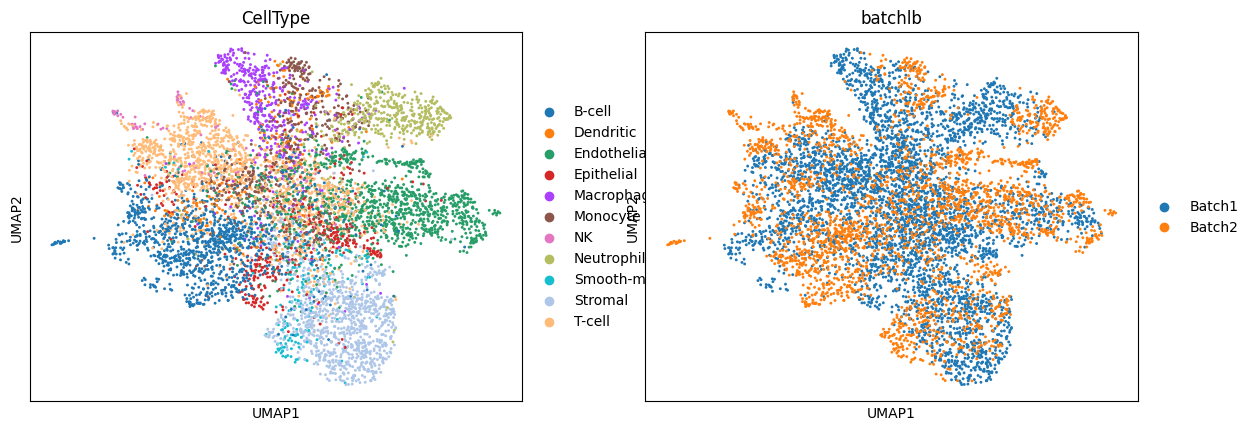

In [6]:
import scanpy as sc
import numpy as np

def plot_umap(adata, embedding):
    adata.obsm['Embedding'] = embedding
    sc.pp.neighbors(adata, use_rep="Embedding")
    sc.tl.umap(adata)
    return sc.pl.umap(adata, show=False, color=['CellType', 'batchlb'],)

path = "/local/home/tomap/scAugmentBench/ablation-db-2/architecture-ablation/MCA/BarlowTwins/32/2/20/embedding.npz"

embedding = np.load(path)['arr_0']

print(embedding.shape)
plot_umap(adata, embedding)

In [63]:
print(adata.obs['CellType'].unique())

['CD16+ Monocytes', 'CD4+ T cells', 'CD14+ Monocytes', 'NKT cells', 'HSPCs', ..., 'Monocyte-derived dendritic cells', 'Plasma cells', 'Erythroid progenitors', 'Megakaryocyte progenitors', 'NK cells']
Length: 16
Categories (16, object): ['CD4+ T cells', 'CD8+ T cells', 'CD10+ B cells', 'CD14+ Monocytes', ..., 'NK cells', 'NKT cells', 'Plasma cells', 'Plasmacytoid dendritic cells']


### Training-DEBUG

In [25]:
import lightning as pl
import logging
import sys

from models.byol_refactor import BYOL
from models.simsiam_refactor import SimSiam
from models.simclr_refactor import SimCLR
from models.barlowtwins_refactor import BarlowTwins
from models.nnclr_refactor import NNCLR
from models.moco_refactor import MoCo
from models.vicreg_refactor import VICReg


from trainer import CheckpointEveryNSteps


train_loader = torch.utils.data.DataLoader(
            train,
            batch_size=256,
            num_workers=12,
            shuffle=True,
            drop_last=True
            )

"""arch = BYOL -- Ref. Done
model = arch(in_dim=train.n_genes, hidden_dim=8, hidden_dim_2=8*2, out_dim=8,)
model = arch(in_dim=train.n_genes, hidden_dim=16, hidden_dim_2=16*2, out_dim=16,)
model = arch(in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=32*2, out_dim=32,) or simply hidden_dim_2?
model = arch(in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=64*2, out_dim=64,)"""
# change code: if hdim2 is None: hdim2 = 2*hdim


"""arch = SimCLR & MoCo -- Ref. Done
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=16, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=8, memory_bank_size=2048)

model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=16, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=8, memory_bank_size=2048)

model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=8, memory_bank_size=2048)"""
# change code: if hdim2 is None: hdim2 = hdim//2


"""arch = BarlowTwins -- Ref. Done
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=64*4)
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=64*2)

model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=32*4)
model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=32*2)

model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16*4, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16*2, memory_bank_size=2048)"""
#arch = BarlowTwins
#model = arch(in_dim=train.n_genes, hidden_dim=8, out_dim=32)


"""
arch = NNCLR -- Ref. Done
model = arch(in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=64, out_dim=16, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=64, out_dim=8, memory_bank_size=2048)

model = arch(in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=32, out_dim=16, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=32, out_dim=8, memory_bank_size=2048)

model = arch(in_dim=train.n_genes, hidden_dim=16, hidden_dim_2=16, out_dim=8, memory_bank_size=2048)
model = arch(in_dim=train.n_genes, hidden_dim=16, hidden_dim_2=16, out_dim=4, memory_bank_size=2048)
"""
# change code: remove hdim2. --> NNCLR(in_dim=train.n_genes, hidden_dim, out_dim, memory_bank_size=2048)


#arch = SimSiam -- Ref. Done
"""
model = arch(in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=64//4, out_dim=64//2)
model = arch(in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=32//4, out_dim=32//2)
model = arch(in_dim=train.n_genes, hidden_dim=16, hidden_dim_2=16//4, out_dim=16//2)
"""
# change code: if hdim2 is None: hdim2 = hdim//4 (or //2)


#arch = VICReg
"""
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=64*4)
model = arch(in_dim=train.n_genes, hidden_dim=64, out_dim=64*2)

model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=32*4)
model = arch(in_dim=train.n_genes, hidden_dim=32, out_dim=32*2)

model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16*4)
model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16*2)
"""
arch = BarlowTwins
model = arch(in_dim=train.n_genes, hidden_dim=16, out_dim=16*2)

device = "cuda" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(max_epochs=30, accelerator=device, callbacks=[CheckpointEveryNSteps(save_step_frequency=10)]) # cpu works for smaller tasks!!

trainer.fit(
    model,
    train_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                      | Params
--------------------------------------------------------------
0 | backbone        | Sequential                | 514 K 
1 | projection_head | BarlowTwinsProjectionHead | 2.7 K 
2 | criterion       | BarlowTwinsLoss           | 0     
--------------------------------------------------------------
517 K     Trainable params
0         Non-trainable params
517 K     Total params
2.069     Total estimated model params size (MB)


Backbone built with dropout 0


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  col

'model2 = arch.load_from_checkpoint(f"/local/home/tomap/scAugmentBench/lightning_logs/version_{i}/checkpoints/checkpoint_epoch=50.ckpt", in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=None, out_dim=32*2, memory_bank_size=2048)\nprint(model2.device)\nembedding = infer_embedding(model2.cpu(), val_loader)\nplot_umap(adata, embedding)'

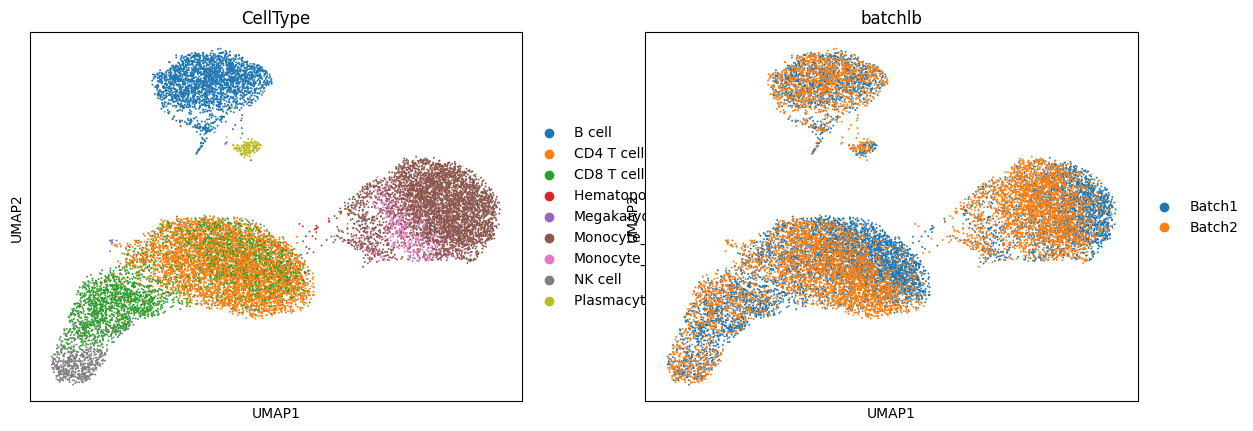

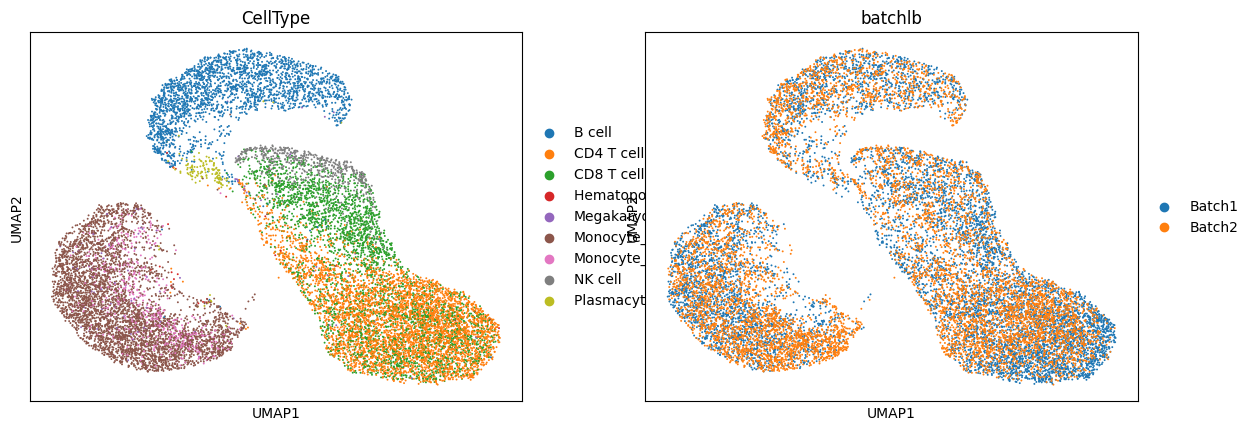

In [26]:
from evaluator import infer_embedding

def plot_umap(adata, embedding):
    adata.obsm['Embedding'] = embedding
    sc.pp.neighbors(adata, use_rep="Embedding")
    sc.tl.umap(adata)
    return sc.pl.umap(adata, show=False, color=['CellType', 'batchlb'],)

def infer_projector_embedding(model, val_loader):
    outs = []
    for x in val_loader:
        with torch.no_grad():
            outs.append(model.projection_head(model.backbone(x[0])))
    
    embedding = torch.concat(outs)
    embedding = np.array(embedding)
    return embedding


val_loader = torch.utils.data.DataLoader(
                    val,
                    batch_size=256,
                    num_workers=1,
                    shuffle=False,
                    drop_last=False)

embedding = infer_embedding(model, val_loader)
plot_umap(adata, embedding)

embedding = infer_projector_embedding(model, val_loader)
plot_umap(adata, embedding)

i = 42

"""model2 = arch.load_from_checkpoint(f"/local/home/tomap/scAugmentBench/lightning_logs/version_{i}/checkpoints/checkpoint_epoch=0.ckpt", in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=128, out_dim=16, memory_bank_size=2048)
print(model2.device)
embedding = infer_embedding(model2.cpu(), val_loader)
plot_umap(adata, embedding)

model2 = arch.load_from_checkpoint(f"/local/home/tomap/scAugmentBench/lightning_logs/version_{i}/checkpoints/checkpoint_epoch=20.ckpt", in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=128, out_dim=16, memory_bank_size=2048)
print(model2.device)
embedding = infer_embedding(model2.cpu(), val_loader)
plot_umap(adata, embedding)

model2 = arch.load_from_checkpoint(f"/local/home/tomap/scAugmentBench/lightning_logs/version_{i}/checkpoints/checkpoint_epoch=40.ckpt", in_dim=train.n_genes, hidden_dim=64, hidden_dim_2=128, out_dim=16, memory_bank_size=2048)
print(model2.device)
embedding = infer_embedding(model2.cpu(), val_loader)
plot_umap(adata, embedding)"""

"""model2 = arch.load_from_checkpoint(f"/local/home/tomap/scAugmentBench/lightning_logs/version_{i}/checkpoints/checkpoint_epoch=50.ckpt", in_dim=train.n_genes, hidden_dim=32, hidden_dim_2=None, out_dim=32*2, memory_bank_size=2048)
print(model2.device)
embedding = infer_embedding(model2.cpu(), val_loader)
plot_umap(adata, embedding)"""

In [4]:
from main import evaluate_model

results, embedding = evaluate_model(model=model,
                                        dataset=val,
                                        adata=adata,
                                        batch_size=256,
                                        num_workers=1,)

results

TypeError: evaluate_model() missing 2 required positional arguments: 'logger' and 'embedding_save_path'

In [119]:
from evaluator import collect_runs, unify_table, scale_table



,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
BarlowTwins,0.4667,0.5337,0.4380,0.5090,0.9790,0.8275,0.1083,0.1153,0.7149,0.9902,0.5512,0.5853,0.5717
BYOL,0.5415,0.5529,0.4392,0.5058,0.9849,0.8539,0.1702,0.1890,0.8168,0.9957,0.6051,0.6048,0.6049
SimSiam,0.4490,0.4125,0.2587,0.4294,0.9498,0.7674,0.0467,0.0499,0.3877,0.9996,0.4502,0.4999,0.4800
NNCLR,0.4989,0.5581,0.4676,0.4858,0.9792,0.8426,0.1510,0.0994,0.7577,0.9996,0.5701,0.5979,0.5868
MoCo,0.5935,0.7310,0.6623,0.5705,0.9988,0.8514,0.0818,0.0751,0.9060,0.9499,0.5728,0.7112,0.6559
SimCLR,0.5634,0.6824,0.6604,0.5312,0.9963,0.8625,0.1494,0.0788,0.8381,0.9994,0.5856,0.6867,0.6463
VICReg,0.5312,0.6316,0.5455,0.5166,0.9827,0.8333,0.1503,0.0714,0.8069,0.9949,0.5714,0.6415,0.6134


### Univariate Augmentation

In [12]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from evaluator import *


def get_bigger_table(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman"):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    augnames = []
    for mname in model_names:
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        representation_dims = os.listdir(tmp)
        hyperparam_strings = []
        for param in representation_dims:
            if mname in ["BarlowTwins", "SimSiam", "NNCLR", "BYOL"]:
                for param_2 in os.listdir(os.path.join(tmp, param)):
                    metrics = []
                    metrics.extend(get_results(os.path.join(tmp, param, param_2)))
                    hyperparam_strings.append("-".join([param, param_2]))
            else:
                tmp = os.path.join(tmp, param)
                hyperparam_strings.append(param)
            
            for i in range(len(metrics)):
                metrics[i]['Model-Architecture'] = mname
                print(param)
                metrics[i]['alpha'] = int(param)
            df = pd.DataFrame(pd.concat(metrics).round(4))#, columns=[seed for seed in os.listdir(os.path.join(tmp, param))])
            ls.append(df)
    #augname = np.unique(np.array(augnames))
    return pd.concat(ls)#, augname[0]

def get_results(path):
    if "mean_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "mean_result.csv"))
    if "std_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "std_result.csv"))
    seeds = os.listdir(path)
    metrics = [pd.read_csv(os.path.join(path, seed, "evaluation_metrics.csv")) for seed in seeds]
    return metrics

def plot_bigger_table_alpha_total(collected_df, name, key="Batch correction", x_label="alpha"):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=['alpha', 'Model-Architecture']))
    collected_df_scaled['alpha'] = collected_df['alpha']
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

    #ax = sns.catplot(x="alpha", y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df, aspect=1.5, errwidth=0.5,).set(title=f'{name} augmentation')
    ax = sns.catplot(x="alpha", y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,).set(title=f'{name} augmentation', xlabel=x_label)
    ax.savefig(f"/local/home/tomap/output/{name}-alphas-{key}.png")
    ax.savefig(f"/local/home/tomap/output/{name}-alphas-{key}.svg")


def plot_bigger_table_scatter(collected_df, name):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=['alpha', 'Model-Architecture']))
    collected_df_scaled['alpha'] = collected_df['alpha']
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

    ax = sns.scatterplot(data=collected_df, x="Batch correction", y="Bio conservation", hue="alpha", style="Model-Architecture",)
    ax.set(title=f'{name} augmentation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.savefig(f"/local/home/tomap/output/{name}-alphas-scatter.png")

df = get_bigger_table(project_root="/local/home/tomap/scAugmentBench/ablation-db-2", dirname="architecture-ablation",
                               dname="MCA")
#plot_bigger_table_scatter(df, augname)
plot_bigger_table(df, "Total", x_label="sigma")

Min num seeds: 3.
Max num seeds: 3.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 3.
Max num seeds: 3.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 2.
Max num seeds: 2.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 2.
Max num seeds: 2.
32
32
32
32
32
16
16
16
16
16
64
64
64
64
64
Min num seeds: 1.
Max num seeds: 1.
32
32
32
32
32
16
16
16
16
16
64
64
64
64
64


NameError: name 'plot_bigger_table' is not defined

### Hidden Dim Choice

Min num seeds: 3.
Max num seeds: 3.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 3.
Max num seeds: 3.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 2.
Max num seeds: 2.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
64
64
64
64
64
Min num seeds: 2.
Max num seeds: 2.
32
32
32
32
32
16
16
16
16
16
64
64
64
64
64
Min num seeds: 1.
Max num seeds: 1.
32
32
32
32
32
16
16
16
16
16
64
64
64
64
64
Min num seeds: 3.
Max num seeds: 3.
32
32
32
32
32
16
16
16
16
16
8
8
8
8
8
128
128
128
128
128
64
64
64
64
64
['#0c71ff', '#ca2800', '#ff28ba', '#000096', '#86e300', '#1c5951']


/tmp/ipykernel_3500373/2200242147.py:78: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(xlabel=x_label)#,title=f'Hidden-Dim-Choice'
/tmp/ipykernel_3500373/2200242147.py:78: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(xlabel=x_label)#,title=f'Hidden-Dim-Choice'
/tmp/ipykernel_3500373/2200242147.py:78: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x

<Figure size 640x480 with 0 Axes>

<Figure size 892.611x500 with 0 Axes>

<Figure size 892.611x500 with 0 Axes>

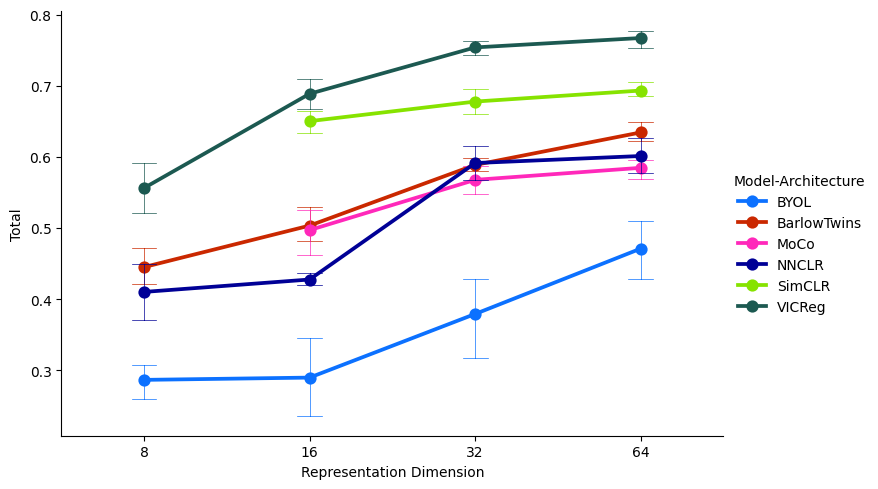

In [34]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from evaluator import *


def get_bigger_table(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman"):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    for mname in model_names:
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        representation_dims = os.listdir(tmp)
        hyperparam_strings = []
        for param in representation_dims:
            if mname in ["BarlowTwins", "SimSiam", "NNCLR", "BYOL", "SimCLR", "MoCo"]:
                for param_2 in os.listdir(os.path.join(tmp, param)):
                    metrics = []
                    metrics.extend(get_results(os.path.join(tmp, param, param_2)))
                    hyperparam_strings.append("-".join([param, param_2]))
            elif mname == "VICReg":
                for param_2 in os.listdir(os.path.join(tmp, param)):
                    for lamda in os.listdir(os.path.join(tmp, param, param_2)):
                        metrics = []
                        metrics.extend(get_results(os.path.join(tmp, param, param_2, lamda)))
            else:
                tmp = os.path.join(tmp, param)
                metrics = get_results(os.path.join(tmp))
                hyperparam_strings.append(param)
            
            for i in range(len(metrics)):
                metrics[i]['Model-Architecture'] = mname
                print(param)
                metrics[i]['hidden_dim'] = int(param)
            df = pd.DataFrame(pd.concat(metrics).round(4))#, columns=[seed for seed in os.listdir(os.path.join(tmp, param))])
            ls.append(df)
    return pd.concat(ls)

def get_results(path):
    if "mean_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "mean_result.csv"))
    if "std_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "std_result.csv"))
    seeds = os.listdir(path)
    metrics = [pd.read_csv(os.path.join(path, seed, "evaluation_metrics.csv")) for seed in seeds]
    return metrics


df = get_bigger_table(project_root="/local/home/tomap/scAugmentBench/ablation-db-2", dirname="architecture-ablation",
                               dname="MCA")


def plot_bigger_table_dim_total(collected_df, key="Batch correction", key_x="hidden_dim", x_label="alpha", palette=None, categories=None):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=[key_x, 'Model-Architecture']))
    collected_df_scaled[key_x] = collected_df[key_x]
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

    plt.clf()
    #ax = sns.catplot(x="alpha", y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df, aspect=1.5, errwidth=0.5,).set(title=f'{name} augmentation')
    ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(xlabel=x_label)#,title=f'Hidden-Dim-Choice'
    ax.savefig(f"/local/home/tomap/output/representation-dimension-ablation-{key}.png")
    ax.savefig(f"/local/home/tomap/output/representation-dimension-ablation-{key}.svg")
    return ax


def plot_bigger_table_scatter(collected_df, name):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=['alpha', 'Model-Architecture']))
    collected_df_scaled['alpha'] = collected_df['alpha']
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

    ax = sns.scatterplot(data=collected_df, x="Batch correction", y="Bio conservation", hue="alpha", style="Model-Architecture",)
    ax.set(title=f'{name} augmentation')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    ax.savefig(f"/local/home/tomap/output/{name}-alphas-scatter.png")

"""df = get_bigger_table(dirname="dimension-ablation-vol2",
                               dname="ImmHuman")"""


import glasbey
labels = np.unique(np.array(df["Model-Architecture"]))
categories=labels
#palette = sns.color_palette("tab10",len(labels))
palette = glasbey.create_palette(palette_size=len(labels), colorblind_safe=True, cvd_severity=50)
print(palette)
label_colors = dict(zip(labels, palette))

"""
df = df[~pd.isna(df['hidden_dim2'])]
df = df[df['hidden_dim']==128]
df['hidden_dim2'] = df['hidden_dim2'].astype(int)
"""
key_x = "hidden_dim"

#df = df.loc[(df['hidden_dim'] > 8) & (df['hidden_dim'] <= 64)]
df = df.loc[(df['hidden_dim'] <= 64)]

ax = plot_bigger_table_dim_total(df, key="Bio conservation", key_x=key_x, x_label="Representation Dimension", palette=palette, categories=categories)
ax = plot_bigger_table_dim_total(df, key="Batch correction", key_x=key_x, x_label="Representation Dimension", palette=palette, categories=categories)
ax = plot_bigger_table_dim_total(df, key="Total", key_x=key_x, x_label="Representation Dimension", palette=palette, categories=categories)

### Projection Factor Choice

In [95]:
def get_bigger_table(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman"):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    for mname in model_names:
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        representation_dims = os.listdir(os.path.join(tmp, "64"))
        hyperparam_strings = []
        for param in representation_dims:
            print(param)
            if mname == "VICReg":
                for lamda in os.listdir(os.path.join(tmp, "64", param)):
                    metrics = []
                    metrics.extend(get_results(os.path.join(tmp, "64", param, lamda)))
            else:
                metrics = get_results(os.path.join(tmp, "64", param))
                hyperparam_strings.append(param)
            
            for i in range(len(metrics)):
                metrics[i]['Model-Architecture'] = mname
                metrics[i]['Projector Output'] = int(param)
            df = pd.DataFrame(pd.concat(metrics).round(4))#, columns=[seed for seed in os.listdir(os.path.join(tmp, param))])
            ls.append(df)
    return pd.concat(ls)



def get_results(path):
    if "mean_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "mean_result.csv"))
    if "std_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "std_result.csv"))
    seeds = os.listdir(path)
    metrics = [pd.read_csv(os.path.join(path, seed, "evaluation_metrics.csv")) for seed in seeds]
    return metrics


def just_scale_total(collected_df, key_x):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=[key_x, 'Model-Architecture']))
    collected_df_scaled[key_x] = collected_df[key_x]
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']
    return collected_df_scaled

df = get_bigger_table(project_root="/local/home/tomap/scAugmentBench/ablation-db-2", dirname="architecture-ablation",
                               dname="MCA")

key_x = "Projector Output"

df_scaled = just_scale_total(df, key_x)

#factor_scalers = ["BYOL", "BarlowTwins", "SimSiam", "VICReg"]
#fixed_scaler = ["MoCo", "SimCLR"]

for mname in os.listdir("/local/home/tomap/scAugmentBench/ablation-db-2/architecture-ablation/MCA"):
    df_scaled[df_scaled['Model-Architecture'] == mname].drop(columns=["Model-Architecture"]).groupby("Projector Output").mean().round(4).sort_values(by="Total", ascending=False).to_csv(f"tables/projector_ablation_means_{mname}.csv")
    df_scaled[df_scaled['Model-Architecture'] == mname].drop(columns=["Model-Architecture"]).groupby("Projector Output").std().round(4).sort_values(by="Total").to_csv(f"tables/projector_ablation_stds_{mname}.csv")

Min num seeds: 3.
Max num seeds: 3.
1
4
2
Min num seeds: 3.
Max num seeds: 3.
1
4
2
Min num seeds: 2.
Max num seeds: 2.
1
2
Min num seeds: 2.
Max num seeds: 2.
16
8
Min num seeds: 3.
Max num seeds: 3.
1
4
2


### Regularization Choice

In [85]:
def get_bigger_table(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman"):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    for mname in ["VICReg"]:
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        for lamda in os.listdir(os.path.join(tmp, "64", "2")):
            print(os.listdir(os.path.join(tmp, "64", "2")))
            metrics = []
            metrics.extend(get_results(os.path.join(tmp, "64", "2", lamda)))

            for i in range(len(metrics)):
                metrics[i]['Model-Architecture'] = mname
                metrics[i]['Lamda'] = float(lamda)
            
            df = pd.DataFrame(pd.concat(metrics).round(4))#, columns=[seed for seed in os.listdir(os.path.join(tmp, param))])
            ls.append(df)
    return pd.concat(ls)



def get_results(path):
    if "mean_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "mean_result.csv"))
    if "std_result.csv" in os.listdir(path):
        os.remove(os.path.join(path, "std_result.csv"))
    seeds = os.listdir(path)
    metrics = [pd.read_csv(os.path.join(path, seed, "evaluation_metrics.csv")) for seed in seeds]
    return metrics


def just_scale_total(collected_df, key_x):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=[key_x, 'Model-Architecture']))
    collected_df_scaled[key_x] = collected_df[key_x]
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']
    return collected_df_scaled

df = get_bigger_table(project_root="/local/home/tomap/scAugmentBench/ablation-db-2", dirname="architecture-ablation",
                               dname="MCA")

key_x = "Lamda"

df_scaled = just_scale_total(df, key_x)

factor_scalers = ["BYOL", "BarlowTwins", "SimSiam", "VICReg"]
fixed_scaler = ["MoCo", "SimCLR"]

df_scaled.sort_values(by="Total")

df_scaled.sort_values(by="Total").drop(columns=["Model-Architecture"]).groupby("Lamda").mean()
#df_scaled.sort_values(by="Total").drop(columns=["Model-Architecture"]).groupby("Lamda").std()

Min num seeds: 3.
Max num seeds: 3.
['1.0', '10.0', '25.0', '5.0']
['1.0', '10.0', '25.0', '5.0']
['1.0', '10.0', '25.0', '5.0']
['1.0', '10.0', '25.0', '5.0']


,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Lamda,,,,,,,,,,,,,
1.0,0.52138,0.53050,0.44672,0.51680,0.95524,0.90152,0.49522,0.30616,0.74602,0.99590,0.644780,0.133808,0.338197
5.0,0.53112,0.60352,0.49822,0.52180,0.97816,0.88758,0.36536,0.26522,0.77452,0.99608,0.493114,0.629988,0.575239
10.0,0.53512,0.60476,0.50640,0.52558,0.98364,0.88278,0.32288,0.25286,0.78364,0.99588,0.414752,0.762021,0.623113
25.0,0.53510,0.60522,0.51146,0.52736,0.98588,0.87616,0.29274,0.28136,0.76320,0.99534,0.289895,0.804875,0.598883


*For VICReg choose (64, 2, 10)*


### Epoch-Choice

Min num seeds: 1.
Max num seeds: 1.


['#0c71ff']


/tmp/ipykernel_3640795/3216467762.py:54: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(title=f'Epoch-Choice', xlabel=x_label)
/tmp/ipykernel_3640795/3216467762.py:54: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(title=f'Epoch-Choice', xlabel=x_label)
/tmp/ipykernel_3640795/3216467762.py:54: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  ax = sns.catplot(x=key_x, y=key, h

<Figure size 640x480 with 0 Axes>

<Figure size 892.611x500 with 0 Axes>

<Figure size 892.611x500 with 0 Axes>

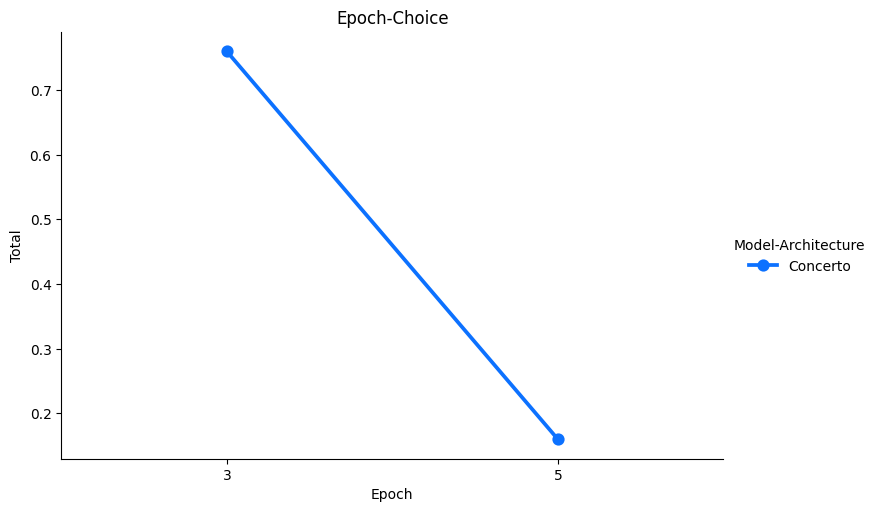

In [37]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from evaluator import *


def get_bigger_table(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman",):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    augnames = []
    for mname in model_names:
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        for param in os.listdir(tmp):
            if "mean_result.csv" in os.listdir(os.path.join(tmp, param)):
                os.remove(os.path.join(tmp, param, "mean_result.csv"))
            if "std_result.csv" in os.listdir(os.path.join(tmp, param)):
                os.remove(os.path.join(tmp, param, "std_result.csv"))
            seeds = os.listdir(os.path.join(tmp, param))
            metrics = [pd.read_csv(os.path.join(tmp, param, seed, "evaluation_metrics.csv")) for seed in seeds]
            
            for i in range(len(metrics)):
                metrics[i]['Model-Architecture'] = mname
                metrics[i]['epochs'] = int(param)
            df = pd.DataFrame(pd.concat(metrics).round(4))#, columns=[seed for seed in os.listdir(os.path.join(tmp, param))])
            ls.append(df)
    return pd.concat(ls)

def plot_bigger_table_dim_total(collected_df, key="Batch correction", key_x="hidden_dim", x_label="alpha", palette=None, categories=None):
    tmp = collected_df.copy()
    collected_df_scaled = scale_table(tmp.drop(columns=[key_x, 'Model-Architecture']))
    collected_df_scaled[key_x] = collected_df[key_x]
    collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

    plt.clf()
    #ax = sns.catplot(x="alpha", y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df, aspect=1.5, errwidth=0.5,).set(title=f'{name} augmentation')
    ax = sns.catplot(x=key_x, y=key, hue="Model-Architecture", kind="point", capsize=.15, data=collected_df_scaled, aspect=1.5, errwidth=0.5,palette=palette, hue_order=categories).set(title=f'Epoch-Choice', xlabel=x_label)
    ax.savefig(f"/local/home/tomap/output/epoch-ablation-{key}.png")
    ax.savefig(f"/local/home/tomap/output/epoch-ablation-{key}.svg")
    return ax

df = get_bigger_table(dirname="augmentation-ablation-concerto-epochs-noaug",
                               dname="ImmHuman")


import glasbey
labels = np.unique(np.array(df["Model-Architecture"]))
categories=labels
#palette = sns.color_palette("tab10",len(labels))
palette = glasbey.create_palette(palette_size=len(labels), colorblind_safe=True, cvd_severity=50)
print(palette)
label_colors = dict(zip(labels, palette))

key_x  = "epochs"

ax = plot_bigger_table_dim_total(df, key="Batch correction", key_x=key_x, x_label="Epoch", palette=palette, categories=categories)
ax = plot_bigger_table_dim_total(df, key="Bio conservation", key_x=key_x, x_label="Epoch", palette=palette, categories=categories)
ax = plot_bigger_table_dim_total(df, key="Total", key_x=key_x, x_label="Epoch", palette=palette, categories=categories)


### Heatmap Plottr

['SimSiam', 'MoCo', 'SimCLR']
SimSiam
Min num seeds: 6.
Max num seeds: 6.
MoCo
Min num seeds: 6.
Max num seeds: 6.
SimCLR
Min num seeds: 6.
Max num seeds: 6.


gauss-mask


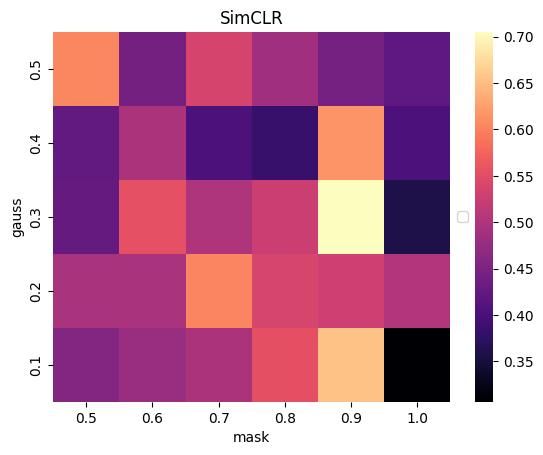

In [149]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from evaluator import *


def get_bigger_table_2params(project_root = "/local/home/tomap/scAugmentBench", dirname = "architecture-ablation",
                 dname = "ImmHuman"):
    root = os.path.join(project_root, dirname, dname)
    model_names = os.listdir(root)
    print(model_names)
    if os.path.exists(os.path.join(root, "final_collected.csv")):
            os.remove(os.path.join(root, "final_collected.csv"))
    
    ls = []
    augnames1 = []
    augnames2 = []
    alphas1 = []
    alphas2 = []
    for mname in model_names:
        print(mname)
        tmp = os.path.join(project_root, dirname, dname, mname)
        
        if os.path.exists(os.path.join(tmp, "mean_result_collected.csv")):
            os.remove(os.path.join(tmp, "mean_result_collected.csv"))
        if os.path.exists(os.path.join(tmp, "std_result_collected.csv")):
            os.remove(os.path.join(tmp, "std_result_collected.csv"))
        
        n_seeds = [len(os.listdir(os.path.join(tmp, param_config))) for param_config in os.listdir(os.path.join(tmp))]
        print(f"Min num seeds: {min(n_seeds)}.\nMax num seeds: {max(n_seeds)}.")

        # get mean and std per parameter-config:
        for param1 in os.listdir(tmp):
            tmp1 = os.path.join(tmp, param1)
            alpha1 = float(param1.split("-")[1])
            augnames1.append(param1.split("-")[0])
            for param2 in os.listdir(tmp1):
                alpha2 = float(param2.split("-")[1])
                metrics = pd.read_csv(os.path.join(tmp1, param2, "20", "evaluation_metrics.csv"))
                augnames2.append(param2.split("-")[0])
                metrics['Model-Architecture'] = mname
                metrics['alpha1'] = float(alpha1)
                metrics['alpha2'] = float(alpha2)
                ls.append(metrics)
        augname = np.unique(np.array(augnames1))
        augname2 = np.unique(np.array(augnames2))
    return pd.concat(ls), "-".join([augname[0], augname2[0]])

def plot_alpha_alpha(collected_df, name):
    for mname in collected_df['Model-Architecture'].unique():
        tmp = collected_df.copy()
        tmp = tmp[tmp['Model-Architecture'] == mname]
        scaled = scale_table(tmp.drop(columns=['alpha1', 'alpha2', 'Model-Architecture']))
        scaled['alpha1'] = tmp['alpha1']
        scaled['alpha2'] = tmp['alpha2']
        #collected_df_scaled['Model-Architecture'] = collected_df['Model-Architecture']

        plt.clf()
        #ax = sns.scatterplot(data=collected_df, x="alpha1", y="alpha2", hue="Total", style="Model-Architecture",)
        ax = sns.heatmap(scaled.pivot(index="alpha1", columns="alpha2", values="Total").iloc[::-1],
            cmap=sns.color_palette("magma", as_cmap=True))
        ax.set(title=f'{mname}', ylabel=f'{name.split("-")[0]}', xlabel=f'{name.split("-")[1]}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        plt.savefig(f"/local/home/tomap/output/{name}-heatmap-{mname}.png")

df, augname = get_bigger_table_2params(dirname="augmentation-ablation-vol8", dname="ImmHuman")
plot_alpha_alpha(df, augname)

print(augname)

#tmp = df.copy()
#tmp = scale_table(tmp.drop(columns=['alpha1', 'alpha2', 'Model-Architecture']))
#tmp[['alpha1', 'alpha2', 'Model-Architecture']] = df[['alpha1', 'alpha2', 'Model-Architecture']]
#sns.heatmap(tmp[tmp['Model-Architecture'] == "SimSiam"].pivot(index="alpha1", columns="alpha2", values="Total"),
#            cmap=sns.color_palette("magma", as_cmap=True))

In [80]:
from evaluator import get_best_params, scale_table, get_bigger_table

#final_pbmc, _ = get_best_params(dirname="dimension-ablation-vol2", dname="PBMC-2D")
final_immune, final_immune_stds = get_best_params(dirname="dimension-ablation-vol2", dname="ImmHuman")
scaled_immune = scale_table(final_immune.copy())

mask_immune, _ = get_best_params(dirname="augmentation-ablation-vol1", dname="ImmHuman")
#bbknn_immune, _ = get_best_params(dirname="augmentation-ablation-vol5", dname="ImmHuman")
crossover_immune, _ = get_best_params(dirname="augmentation-ablation-vol4", dname="ImmHuman")
gauss_immune, _ = get_best_params(dirname="augmentation-ablation-vol2", dname="ImmHuman")
innerswap_immune, _ = get_best_params(dirname="augmentation-ablation-vol3", dname="ImmHuman")

#scaled_pbmc = scale_table(final_pbmc.copy())
scaled_mask_immune = scale_table(mask_immune.copy())
#scaled_bbknn_immune = scale_table(bbknn_immune.copy())
scaled_crossover_immune = scale_table(crossover_immune.copy())
scaled_innerswap_immune = scale_table(innerswap_immune.copy())
scaled_gauss_immune = scale_table(gauss_immune.copy())


#final_pbmc.to_csv("pbmc_2d-dimensions.csv")
#scaled_pbmc.to_csv("pbmc_2d-dimensions-scaled.csv")

final_immune.to_csv("immhuman-dimensions.csv")
scaled_immune.to_csv("immhuman-dimensions-scaled.csv")

#bbknn_immune.to_csv("immhuman-bbknn.csv")
#scaled_bbknn_immune.to_csv("immhuman-bbknn-scaled.csv")

crossover_immune.to_csv("immhuman-crossover.csv")
scaled_crossover_immune.to_csv("immhuman-crossover-scaled.csv")

innerswap_immune.to_csv("immhuman-innerswap.csv")
scaled_innerswap_immune.to_csv("immhuman-innerswap-scaled.csv")

gauss_immune.to_csv("immhuman-gauss.csv")
scaled_gauss_immune.to_csv("immhuman-gauss-scaled.csv")


Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 1.
Max num seeds: 5.
Min num seeds: 1.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 7.
Min num seeds: 5.
Max num seeds: 5.
Min num seeds: 5.
Max num seeds: 5.


In [6]:
# functions to split index into required information
import numpy as np

def print_latex_table(means, stds):
    assert means is not None and stds is not None, "Must call .unify_runs() before printing unified tables."
    print("Metrics:")
    print(means.sort_index().round(3).to_latex(index=True, float_format="${:.3f}$".format,))
    print("-----")
    print("STD:")
    print(stds.sort_index().round(3).to_latex(index=True, float_format="${:.3f}$".format,))
    
def print_combined_latex_table(means, stds):
    assert means is not None and stds is not None, "Must call .unify_runs() before printing unified tables."
    # Combine means and stds into a single DataFrame with the format "mean ± std"
    combined = means.sort_index().round(3).astype(str) + " $\pm$ " + stds.sort_index().round(3).astype(str)        
    # Print the combined DataFrame in LaTeX format
    print("Metrics (Mean $\pm$ STD):")
    print(combined.to_latex(index=True, escape=False))

def transform_index_architecture_ablation(df):
    mname = list(map(lambda x: x.split("-")[0], list(df.index)))
    param = list(map(lambda x: "-".join(x.split("-")[1:]), list(df.index)))
    return mname, param

def transform_index_aug_ablation(df):
    mname = list(map(lambda x: x.split("-")[0], list(df.index)))
    augname = list(map(lambda x: x.split("-")[1], list(df.index)))
    alpha = list(map(lambda x: x.split("-")[2], list(df.index)))
    return mname, augname, alpha

arch, hdims = transform_index_architecture_ablation(scaled_immune)
#model, aug, alpha = transform_index_aug_ablation(mask_immune)
tmp = scaled_immune.copy()
tmp['architecture'] = arch
tmp['hidden1-hidden2'] = hdims

top_models = []
for model in np.unique(np.array(arch)):
    top_models.append("-".join([model, tmp[tmp['architecture'] == model].sort_values('Total', ascending=False).iloc[0]['hidden1-hidden2']]))

print(f"\nBest parameters per architecture:\n{top_models}\n")

scaled_immune.loc[top_models]

#final_immune_stds.loc[top_models][["Batch correction", "Bio conservation", "Total"]]

print_combined_latex_table(scaled_immune.loc[top_models][["Batch correction", "Bio conservation", "Total"]], final_immune_stds.loc[top_models][["Batch correction", "Bio conservation", "Total"]])
#scaled_immune.sort_values("Total", ascending=False)


Best parameters per architecture:
['BYOL-128', 'BarlowTwins-128', 'MoCo-16', 'NNCLR-256-256', 'SimCLR-128', 'SimSiam-256-256', 'VICReg-64']

Metrics (Mean $\pm$ STD):
\begin{tabular}{llll}
\toprule
 & Batch correction & Bio conservation & Total \\
\midrule
BYOL-128 & 0.874 $\pm$ 0.014 & 0.605 $\pm$ 0.029 & 0.712 $\pm$ 0.018 \\
BarlowTwins-128 & 0.603 $\pm$ 0.009 & 0.481 $\pm$ 0.016 & 0.53 $\pm$ 0.013 \\
MoCo-16 & 0.725 $\pm$ 0.008 & 0.891 $\pm$ 0.009 & 0.825 $\pm$ 0.005 \\
NNCLR-256-256 & 0.774 $\pm$ 0.01 & 0.706 $\pm$ 0.021 & 0.733 $\pm$ 0.013 \\
SimCLR-128 & 0.765 $\pm$ 0.005 & 0.849 $\pm$ 0.016 & 0.815 $\pm$ 0.011 \\
SimSiam-256-256 & 0.891 $\pm$ 0.015 & 0.728 $\pm$ 0.022 & 0.793 $\pm$ 0.012 \\
VICReg-64 & 0.635 $\pm$ 0.003 & 0.731 $\pm$ 0.007 & 0.693 $\pm$ 0.004 \\
\bottomrule
\end{tabular}



blue
green
red


<Figure size 640x480 with 0 Axes>

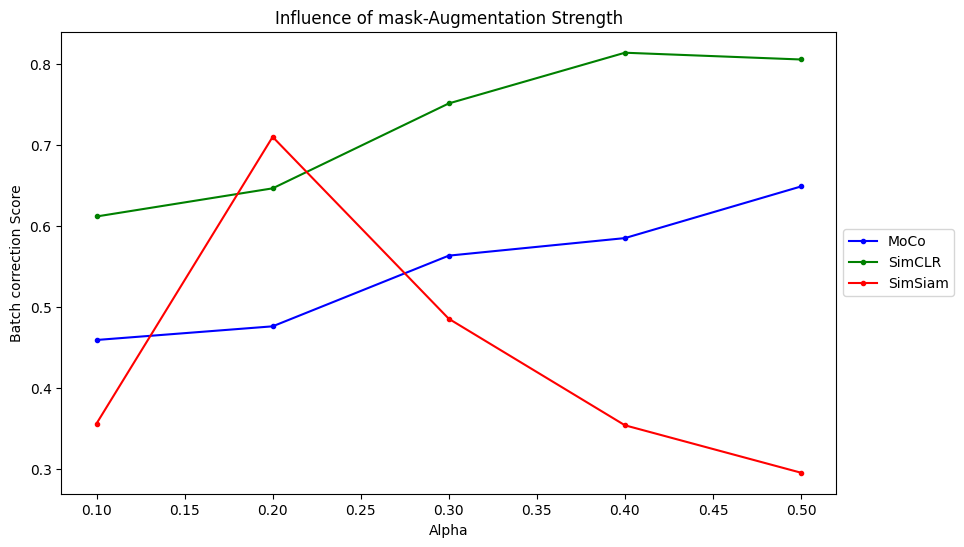

In [53]:
import matplotlib.pyplot as plt
import numpy as np

colors = {"MoCo": 'blue', "SimCLR": 'green', "SimSiam": 'red'}

def plot_alpha_to_total(df, aug, metric):
    mname, _, alphas = transform_index_aug_ablation(df.sort_index())
    alphas = [float(a) for a in alphas]
    totals = np.array(df.sort_index()[metric])
    
    plt.clf()
    plt.figure(figsize=(10, 6))
    for i in range(len(np.unique(np.array(mname)))):
        model = mname[len(mname)//3*i]
        print(colors[model])
        plt.plot(alphas[len(mname)//3*i:len(mname)//3*(i+1)], totals[len(mname)//3*i:len(mname)//3*(i+1)], color=colors[model], marker='.', label=model)

    plt.xlabel('Alpha')
    plt.ylabel(f'{metric} Score')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Influence of {aug}-Augmentation Strength')
    plt.savefig(f"/local/home/tomap/output/.png")

plot_alpha_to_total(scaled_mask_immune, "mask", "Batch correction")

In [29]:
import pandas as pd
# Function to join the csvs:
scale_table(pd.concat([bbknn_immune, mask_immune, gauss_immune, innerswap_immune, crossover_immune]).copy()).sort_values(by="Total", ascending=False).round(4).to_csv("test.csv")

In [16]:
#scaled.sort_values("Batch correction")
#scaled.sort_values("Bio conservation")
#top10_pbmc = scaled_pbmc.sort_values("Total", ascending=False).index[:10]
#print(f"Top-10 PBMC Models:\n{list(top10_pbmc)}")

top10_immune = scaled_immune.sort_values("Total", ascending=False).index[:10]

print(f"Top-10 Immune-Human Models:\n{list(top10_immune)}")
scaled_immune
#final_immune

Top-10 Immune-Human Models:
['MoCo-16', 'SimCLR-128', 'SimSiam-256-256', 'MoCo-32', 'SimCLR-64', 'MoCo-64', 'MoCo-128', 'SimCLR-32', 'SimSiam-256-128', 'SimCLR-16']


,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
BarlowTwins-32,0.4407,0.4591,0.3543,0.4924,0.9693,0.8023,0.1389,0.1399,0.5787,0.9933,0.569803,0.345921,0.435474
BarlowTwins-16,0.4331,0.3707,0.1954,0.4581,0.9535,0.7827,0.1230,0.1269,0.4514,0.9848,0.403385,0.134135,0.241835
BarlowTwins-128,0.4694,0.5205,0.4103,0.5075,0.9787,0.8268,0.1181,0.1190,0.7191,0.9915,0.603066,0.481287,0.529999
BarlowTwins-64,0.4440,0.5208,0.4165,0.5034,0.9766,0.8222,0.1114,0.1454,0.6132,0.9920,0.582035,0.443745,0.499061
BYOL-32,0.5237,0.5167,0.4091,0.4758,0.9768,0.8361,0.1693,0.1601,0.7502,0.9932,0.777251,0.492969,0.606682
BYOL-16,0.5043,0.4357,0.2744,0.4639,0.9684,0.8124,0.1591,0.1536,0.6182,0.9961,0.668118,0.334428,0.467904
BYOL-128,0.5291,0.5660,0.4486,0.5012,0.9868,0.8470,0.1657,0.1934,0.8162,0.9962,0.873778,0.604909,0.712456
BYOL-64,0.5314,0.5434,0.4259,0.4879,0.9803,0.8435,0.1604,0.1525,0.7874,0.9963,0.795719,0.548414,0.647336
SimSiam-128-128,0.5356,0.6058,0.5189,0.5054,0.9852,0.8569,0.1674,0.1358,0.7958,0.9995,0.832109,0.659387,0.728476
SimSiam-16-12,0.4943,0.4194,0.3078,0.4729,0.9633,0.8304,0.1110,0.1275,0.5991,0.9996,0.605223,0.321826,0.435185


In [47]:
scaled_bbknn_immune.sort_index()#.sort_values("Total", ascending=False)#.index[:10]scaled_bbknn_immune

,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
MoCo-bbknn-0.1,0.4975,0.6283,0.5458,0.5411,0.9904,0.8726,0.1499,0.1811,0.7406,0.9689,0.350992,0.472493,0.423892
MoCo-bbknn-0.2,0.4994,0.6393,0.5339,0.5359,0.9919,0.8708,0.1646,0.1979,0.7614,0.9594,0.394347,0.488876,0.451064
MoCo-bbknn-0.3,0.5144,0.6482,0.5415,0.5357,0.9944,0.8645,0.1683,0.1858,0.7941,0.9651,0.452211,0.587236,0.533226
MoCo-bbknn-0.4,0.5212,0.6528,0.5205,0.5297,0.9947,0.8584,0.1751,0.1689,0.8133,0.9661,0.461588,0.572094,0.527891
MoCo-bbknn-0.5,0.5237,0.6601,0.5398,0.5266,0.9946,0.8592,0.1788,0.1775,0.8223,0.9697,0.519654,0.602789,0.569535
MoCo-bbknn-0.6,0.5267,0.6640,0.5514,0.5267,0.9944,0.8620,0.1820,0.1907,0.8183,0.9702,0.550868,0.627473,0.596831
SimCLR-bbknn-0.1,0.5133,0.6407,0.5697,0.5218,0.9941,0.8843,0.1853,0.1866,0.7271,0.9994,0.593398,0.561754,0.574412
SimCLR-bbknn-0.2,0.5146,0.6574,0.5847,0.5097,0.9964,0.8769,0.1813,0.1991,0.7429,0.9994,0.613616,0.611592,0.612402
SimCLR-bbknn-0.3,0.5200,0.6679,0.6065,0.4948,0.9970,0.8764,0.1856,0.2042,0.7504,0.9995,0.643543,0.634033,0.637837
SimCLR-bbknn-0.4,0.5354,0.6629,0.5613,0.4877,0.9974,0.8747,0.1914,0.2037,0.7710,0.9995,0.687227,0.592272,0.630254


In [9]:
scaled_bbknn_immune.sort_values("Total", ascending=False)#.index[:10]

,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
SimCLR-bbknn-0.5,0.5448,0.6721,0.5542,0.4820,0.9973,0.8753,0.1957,0.2038,0.8035,0.9995,0.735277,0.681699,0.703130
SimCLR-bbknn-0.4,0.5354,0.6629,0.5613,0.4877,0.9974,0.8747,0.1914,0.2037,0.7710,0.9995,0.657635,0.663075,0.660899
SimCLR-bbknn-0.3,0.5200,0.6679,0.6065,0.4948,0.9970,0.8764,0.1856,0.2042,0.7504,0.9995,0.608555,0.694551,0.660152
SimSiam-bbknn-0.5,0.5141,0.6622,0.5742,0.5442,0.9980,0.8187,0.1425,0.1752,0.8180,0.9995,0.412058,0.800804,0.645305
SimCLR-bbknn-0.2,0.5146,0.6574,0.5847,0.5097,0.9964,0.8769,0.1813,0.1991,0.7429,0.9994,0.573413,0.668781,0.630634
SimSiam-bbknn-0.3,0.4826,0.6569,0.6410,0.5383,0.9962,0.8412,0.1628,0.2082,0.7630,0.9995,0.485462,0.722750,0.627835
SimSiam-bbknn-0.2,0.4922,0.6300,0.6178,0.5302,0.9936,0.8637,0.1890,0.2336,0.7534,0.9994,0.647553,0.605692,0.622436
MoCo-bbknn-0.5,0.5237,0.6601,0.5398,0.5266,0.9946,0.8592,0.1788,0.1775,0.8223,0.9697,0.481332,0.672246,0.595880
SimCLR-bbknn-0.1,0.5133,0.6407,0.5697,0.5218,0.9941,0.8843,0.1853,0.1866,0.7271,0.9994,0.545953,0.615677,0.587787
MoCo-bbknn-0.3,0.5144,0.6482,0.5415,0.5357,0.9944,0.8645,0.1683,0.1858,0.7941,0.9651,0.410252,0.648219,0.553032


In [54]:
scaled_bbknn_immune.sort_index()#sort_values("Total", ascending=False)#.index[:10]

,Isolated labels,Leiden NMI,Leiden ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
MoCo-bbknn-0.1,0.4975,0.6283,0.5458,0.5411,0.9904,0.8726,0.1499,0.1811,0.7406,0.9689,0.350992,0.472493,0.423892
MoCo-bbknn-0.2,0.4994,0.6393,0.5339,0.5359,0.9919,0.8708,0.1646,0.1979,0.7614,0.9594,0.394347,0.488876,0.451064
MoCo-bbknn-0.3,0.5144,0.6482,0.5415,0.5357,0.9944,0.8645,0.1683,0.1858,0.7941,0.9651,0.452211,0.587236,0.533226
MoCo-bbknn-0.4,0.5212,0.6528,0.5205,0.5297,0.9947,0.8584,0.1751,0.1689,0.8133,0.9661,0.461588,0.572094,0.527891
MoCo-bbknn-0.5,0.5237,0.6601,0.5398,0.5266,0.9946,0.8592,0.1788,0.1775,0.8223,0.9697,0.519654,0.602789,0.569535
MoCo-bbknn-0.6,0.5267,0.6640,0.5514,0.5267,0.9944,0.8620,0.1820,0.1907,0.8183,0.9702,0.550868,0.627473,0.596831
SimCLR-bbknn-0.1,0.5133,0.6407,0.5697,0.5218,0.9941,0.8843,0.1853,0.1866,0.7271,0.9994,0.593398,0.561754,0.574412
SimCLR-bbknn-0.2,0.5146,0.6574,0.5847,0.5097,0.9964,0.8769,0.1813,0.1991,0.7429,0.9994,0.613616,0.611592,0.612402
SimCLR-bbknn-0.3,0.5200,0.6679,0.6065,0.4948,0.9970,0.8764,0.1856,0.2042,0.7504,0.9995,0.643543,0.634033,0.637837
SimCLR-bbknn-0.4,0.5354,0.6629,0.5613,0.4877,0.9974,0.8747,0.1914,0.2037,0.7710,0.9995,0.687227,0.592272,0.630254


Masking:
- SimCLR -> __0.4__, 0.5, 0.2
- SimSiam -> __0.2__, 0.3, 0.4
- MoCo -> __0.5__, 0.4, 0.3

BBKNN:
- All are best with alpha=0.5

--> best should lie somewhere around [0.35, 0.45]

### SCIBN-Rerun

In [19]:
from evaluator import recalculate_results
import numpy as np
from main import reset_random_seeds


path = "/local/home/tomap/scAugmentBench/augmentation-ablation-vol4/ImmHuman/SimSiam/crossover-0.1/20"
reset_random_seeds(int(path.split("/")[-1]))

emb = np.load(os.path.join(path, "embedding.npz"))['arr_0']
results = recalculate_results(adata, emb, 12)
results.to_csv(os.path.join(path, 'evaluation_metrics.csv'), index=None)

Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

In [11]:
import shutil
from evaluator import recalculate_results
import numpy as np
from main import reset_random_seeds

dname_root = "/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman"
#adata = load_data!!!

for mname in os.listdir(dname_root):
    for param in os.listdir(os.path.join(dname_root, mname)):
        for param2 in os.listdir(os.path.join(dname_root, mname, param)):
            for seed in  os.listdir(os.path.join(dname_root, mname, param, param2)):
                tmp = os.path.join(dname_root, mname, param, param2)
                if not os.path.exists(os.path.join(tmp, seed,"evaluation_metrics.csv")):
                    print(os.path.join(tmp, seed,))
                    reset_random_seeds(int(seed))
                    # recalculate scib-metrics.
                    if not os.path.exists(os.path.join(tmp, seed, "embedding.npz")):
                        print(f"Removing {os.path.join(tmp, seed)} (no embedding)")
                        shutil.rmtree(os.path.join(tmp, seed))
                    else:
                        print(f"Calculate @ {os.path.join(tmp, seed)}")
                        emb = np.load(os.path.join(tmp, seed, "embedding.npz"))['arr_0']
                        results = recalculate_results(adata, emb, 12)
                        results.to_csv(os.path.join(tmp, seed, 'evaluation_metrics.csv'), index=None)

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.5/20


Computing neighbors:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]2024-08-26 09:13:49.880454: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.3.107). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.5/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.2/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.1/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.3/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimSiam/innerswap-0.4/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.5/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.2/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.1/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.3/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/MoCo/innerswap-0.4/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.5/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.2/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.1/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.3/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.1/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.1/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.3/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.3/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.2/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.2/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.4/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman/SimCLR/innerswap-0.4/mask-0.4/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

In [12]:
def get_lost_benchmarks(adata, dname_root = "/local/home/tomap/scAugmentBench/augmentation-ablation-vol6/ImmHuman"):
    for mname in os.listdir(dname_root):
        for param in os.listdir(os.path.join(dname_root, mname)):
            for param2 in os.listdir(os.path.join(dname_root, mname, param)):
                for seed in  os.listdir(os.path.join(dname_root, mname, param, param2)):
                    tmp = os.path.join(dname_root, mname, param, param2)
                    if not os.path.exists(os.path.join(tmp, seed,"evaluation_metrics.csv")):
                        print(os.path.join(tmp, seed,))
                        reset_random_seeds(int(seed))
                        # recalculate scib-metrics.
                        if not os.path.exists(os.path.join(tmp, seed, "embedding.npz")):
                            print(f"Removing {os.path.join(tmp, seed)} (no embedding)")
                            shutil.rmtree(os.path.join(tmp, seed))
                        else:
                            print(f"Calculate @ {os.path.join(tmp, seed)}")
                            emb = np.load(os.path.join(tmp, seed, "embedding.npz"))['arr_0']
                            results = recalculate_results(adata, emb, 12)
                            results.to_csv(os.path.join(tmp, seed, 'evaluation_metrics.csv'), index=None)


get_lost_benchmarks(adata, "/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman")
get_lost_benchmarks(adata, "/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman")

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.5/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.2/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.1/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.3/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimSiam/innerswap-0.4/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.5/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.2/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.1/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.3/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/MoCo/innerswap-0.4/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.5/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.2/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.1/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.3/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol7/ImmHuman/SimCLR/innerswap-0.4/gauss-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.4/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.2/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.1/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.3/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimSiam/gauss-0.5/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.4/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.2/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.1/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.3/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/MoCo/gauss-0.5/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.4/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.2/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.1/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.3/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.6/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.6/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.5/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.5/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.7/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.7/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.8/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.8/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.9/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-0.9/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

/local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-1.0/20
Calculate @ /local/home/tomap/scAugmentBench/augmentation-ablation-vol8/ImmHuman/SimCLR/gauss-0.5/mask-1.0/20


Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts i

### DEBUG

/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/home/tomap/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  col

[<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>]

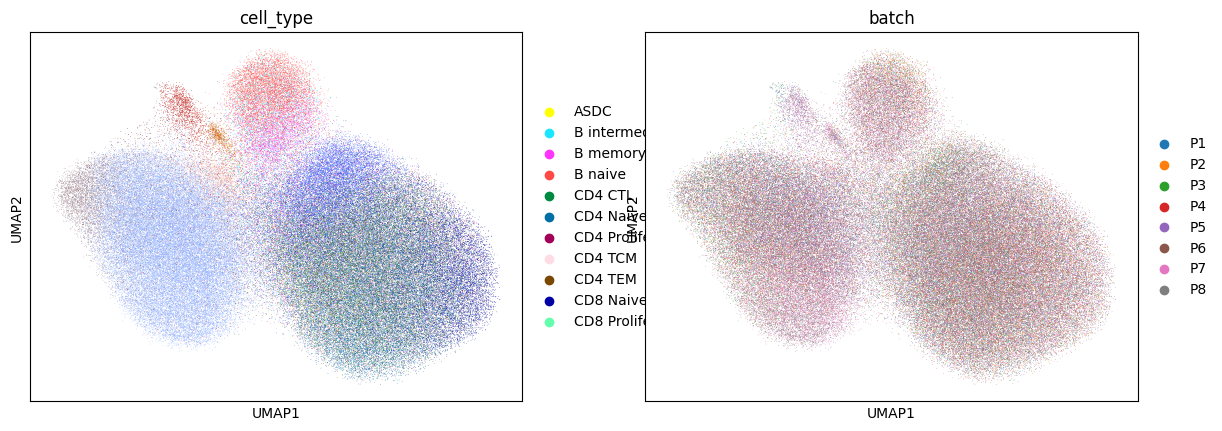

In [7]:
import scanpy as sc
import numpy as np

ad = sc.read_h5ad("../AugmentationPaper/adata_RNA_full.h5ad")

def plot_umap(adata, embedding):
    adata.obsm['Embedding'] = embedding
    sc.pp.neighbors(adata, use_rep="Embedding")
    sc.tl.umap(adata)
    return sc.pl.umap(adata, show=False, color=['cell_type', 'batch'],)

path = "../AugmentationPaper/embedding (1).npz"

embedding = np.load(path)['arr_0']
plot_umap(ad, embedding)

In [4]:
ad

AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'batch', 'cell_type', 'obs_names', 'cell_type_l1'
    var: 'var_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'Embedding'
    obsp: 'distances', 'connectivities'